# Classifiers - NC - busy vs relaxed - with TFv1
Exploring different classifiers with with the contractive autoencoder for the NC task. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution() # required for the contractive autoencoder
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        if cog_res['task_label'][task_num_table] != 'NC':
            continue
        
        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=10):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='relu', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='sigmoid', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

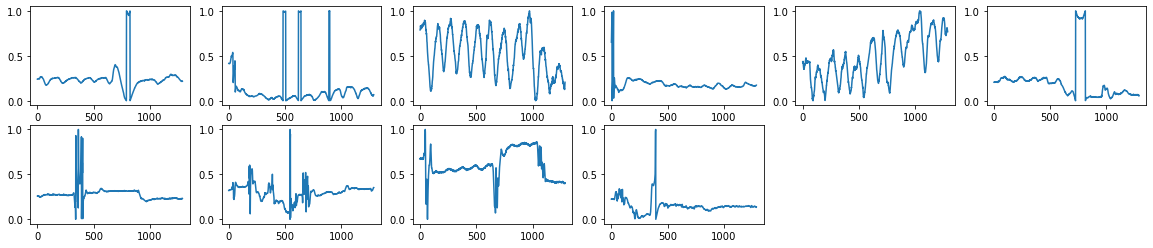

<Figure size 432x288 with 0 Axes>

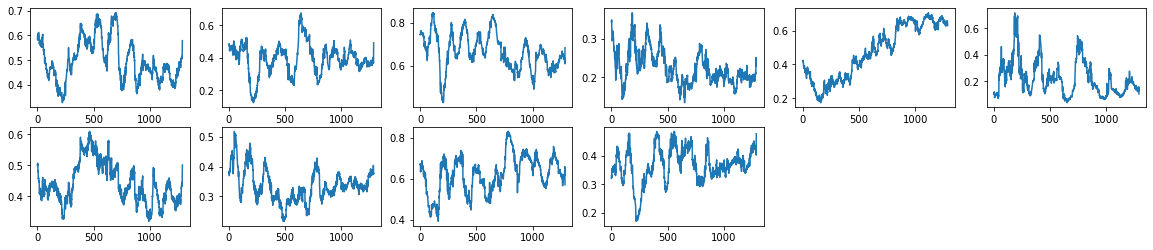

In [19]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

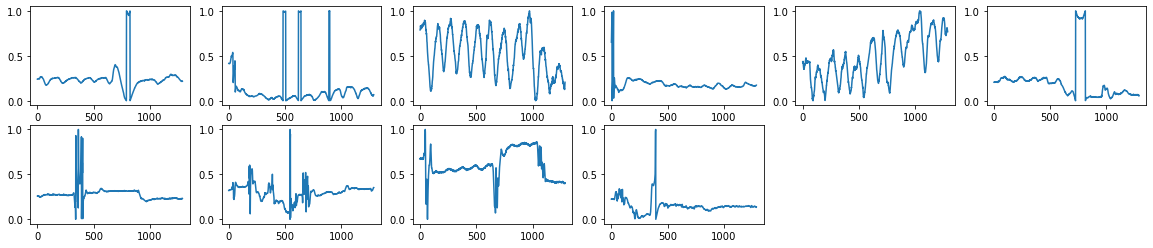

<Figure size 432x288 with 0 Axes>

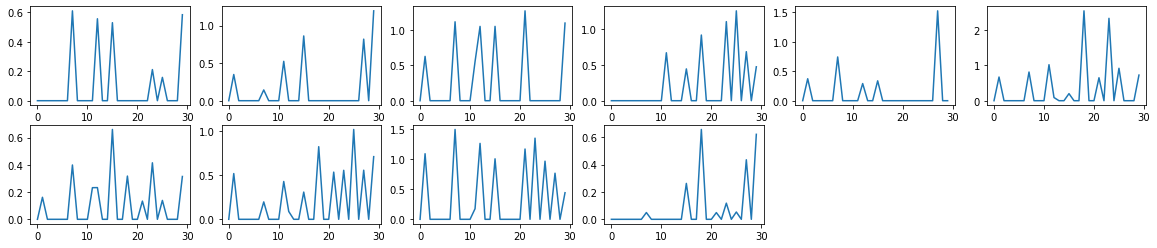

In [20]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [22]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [23]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale valid and test with train's scaler
                    valid_x = sscaler.transform(valid_x)
                    test_x = sscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [24]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [25]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [26]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_ae_enc
    if (data_name == 'phase'):
        params = params_dense_phase
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [27]:
accs = helper_loop(dense_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.006980
iteration: 2 of 23 ; time elapsed: 0:00:04.087795
iteration: 3 of 23 ; time elapsed: 0:00:08.374288
iteration: 4 of 23 ; time elapsed: 0:00:12.767182
iteration: 5 of 23 ; time elapsed: 0:00:17.302137
iteration: 6 of 23 ; time elapsed: 0:00:23.379664
iteration: 7 of 23 ; time elapsed: 0:00:30.801825
iteration: 8 of 23 ; time elapsed: 0:00:37.662005
iteration: 9 of 23 ; time elapsed: 0:00:45.163847
iteration: 10 of 23 ; time elapsed: 0:00:51.389902
iteration: 11 of 23 ; time elapsed: 0:00:58.469361
iteration: 12 of 23 ; time elapsed: 0:01:04.487588
iteration: 13 of 23 ; time elapsed: 0:01:10.763353
iteration: 14 of 23 ; time elapsed: 0:01:17.371669
iteration: 15 of 23 ; time elapsed: 0:01:24.479614
iteration: 16 of 23 ; time elapsed: 0:01:31.686004
iteration: 17 of 23 ; time elapsed: 0:01:39.105468
iteration: 18 of 23 ; time elapsed: 0:01:46.764989
iteration: 19 of 23 ; time elapsed: 0:01:54.592276
iteration: 20 of 23 ; time elapsed: 0:02

In [28]:
accuracies['simple_dense'] = accs

In [29]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.750000,62i9y
1,0.833333,0.500000,2gu87
2,1.000000,1.000000,iz2ps
3,0.666667,0.833333,1mpau
4,0.666667,0.833333,7dwjy
5,0.500000,0.666667,7swyk
6,0.666667,1.000000,94mnx
7,0.666667,1.000000,bd47a
8,0.833333,0.500000,c24ur
9,0.666667,0.666667,ctsax


In [30]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.166667     0.500000
max     1.000000     1.000000
mean    0.630435     0.764493
median  0.666667     0.833333


#### LSTM-based classifier  
based on the original author's code

In [31]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [32]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [33]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_ae_enc
    if (data_name == 'phase'):
        params = params_lstm_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.007980
iteration: 2 of 23 ; time elapsed: 0:00:23.646851
iteration: 3 of 23 ; time elapsed: 0:00:47.930122
iteration: 4 of 23 ; time elapsed: 0:01:12.846093
iteration: 5 of 23 ; time elapsed: 0:01:38.669641
iteration: 6 of 23 ; time elapsed: 0:02:05.456869
iteration: 7 of 23 ; time elapsed: 0:02:34.559935
iteration: 8 of 23 ; time elapsed: 0:03:02.335360
iteration: 9 of 23 ; time elapsed: 0:03:30.713555
iteration: 10 of 23 ; time elapsed: 0:04:00.654116
iteration: 11 of 23 ; time elapsed: 0:04:31.345171
iteration: 12 of 23 ; time elapsed: 0:05:02.678648
iteration: 13 of 23 ; time elapsed: 0:05:35.705147
iteration: 14 of 23 ; time elapsed: 0:06:11.550198
iteration: 15 of 23 ; time elapsed: 0:06:46.361540
iteration: 16 of 23 ; time elapsed: 0:07:24.210436
iteration: 17 of 23 ; time elapsed: 0:08:02.714981
iteration: 18 of 23 ; time elapsed: 0:08:43.742226
iteration: 19 of 23 ; time elapsed: 0:09:31.450759
iteration: 20 of 23 ; time elapsed: 0:10

In [35]:
accuracies['LSTM'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.250000,0.500000,62i9y
1,0.666667,0.500000,2gu87
2,1.000000,0.500000,iz2ps
3,0.666667,0.500000,1mpau
4,0.833333,0.666667,7dwjy
5,0.500000,0.666667,7swyk
6,1.000000,0.333333,94mnx
7,1.000000,0.833333,bd47a
8,0.500000,0.333333,c24ur
9,0.833333,0.666667,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.250000     0.166667
max     1.000000     0.833333
mean    0.742754     0.565217
median  0.666667     0.500000


#### kNN

In [38]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [39]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [40]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [41]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_ae_enc
    if (data_name == 'phase'):
        params = params_knn_phase
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [42]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.017951
iteration: 2 of 23 ; time elapsed: 0:00:00.119680
iteration: 3 of 23 ; time elapsed: 0:00:00.150597
iteration: 4 of 23 ; time elapsed: 0:00:00.181515
iteration: 5 of 23 ; time elapsed: 0:00:00.211433
iteration: 6 of 23 ; time elapsed: 0:00:00.247338
iteration: 7 of 23 ; time elapsed: 0:00:00.276260
iteration: 8 of 23 ; time elapsed: 0:00:00.308177
iteration: 9 of 23 ; time elapsed: 0:00:00.338097
iteration: 10 of 23 ; time elapsed: 0:00:00.369014
iteration: 11 of 23 ; time elapsed: 0:00:00.402923
iteration: 12 of 23 ; time elapsed: 0:00:00.439822
iteration: 13 of 23 ; time elapsed: 0:00:00.470739
iteration: 14 of 23 ; time elapsed: 0:00:00.500660
iteration: 15 of 23 ; time elapsed: 0:00:00.536564
iteration: 16 of 23 ; time elapsed: 0:00:00.566485
iteration: 17 of 23 ; time elapsed: 0:00:00.595408
iteration: 18 of 23 ; time elapsed: 0:00:00.627322
iteration: 19 of 23 ; time elapsed: 0:00:00.659235
iteration: 20 of 23 ; time elapsed: 0:00

In [43]:
accuracies['kNN'] = accs

In [44]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.750000,62i9y
1,0.833333,0.500000,2gu87
2,0.666667,0.666667,iz2ps
3,0.666667,0.500000,1mpau
4,0.666667,0.833333,7dwjy
5,0.500000,0.500000,7swyk
6,0.500000,0.833333,94mnx
7,0.833333,1.000000,bd47a
8,0.333333,0.333333,c24ur
9,0.666667,0.666667,ctsax


In [45]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.333333     0.333333
max     0.833333     1.000000
mean    0.630435     0.713768
median  0.666667     0.666667


####  SVC

In [46]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [47]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [48]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [49]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_ae_enc
    if (data_name == 'phase'):
        params = params_svc_phase
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [50]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00.006980
iteration: 2 of 23 ; time elapsed: 0:00:00.218416
iteration: 3 of 23 ; time elapsed: 0:00:00.407087
iteration: 4 of 23 ; time elapsed: 0:00:00.596130
iteration: 5 of 23 ; time elapsed: 0:00:00.785856
iteration: 6 of 23 ; time elapsed: 0:00:00.979533
iteration: 7 of 23 ; time elapsed: 0:00:01.175015
iteration: 8 of 23 ; time elapsed: 0:00:01.373484
iteration: 9 of 23 ; time elapsed: 0:00:01.554002
iteration: 10 of 23 ; time elapsed: 0:00:01.734976
iteration: 11 of 23 ; time elapsed: 0:00:01.911503
iteration: 12 of 23 ; time elapsed: 0:00:02.095796
iteration: 13 of 23 ; time elapsed: 0:00:02.267876
iteration: 14 of 23 ; time elapsed: 0:00:02.437596
iteration: 15 of 23 ; time elapsed: 0:00:02.599164
iteration: 16 of 23 ; time elapsed: 0:00:02.760731
iteration: 17 of 23 ; time elapsed: 0:00:02.917314
iteration: 18 of 23 ; time elapsed: 0:00:03.081873
iteration: 19 of 23 ; time elapsed: 0:00:03.246433
iteration: 20 of 23 ; time elapsed: 0:00

In [51]:
accuracies['SVC'] = accs

In [52]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.750000,0.750000,62i9y
1,0.666667,0.666667,2gu87
2,1.000000,1.000000,iz2ps
3,0.500000,0.666667,1mpau
4,0.833333,0.833333,7dwjy
5,0.500000,0.666667,7swyk
6,0.666667,0.833333,94mnx
7,0.833333,1.000000,bd47a
8,0.333333,0.500000,c24ur
9,0.833333,0.666667,ctsax


In [53]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.333333     0.500000
max     1.000000     1.000000
mean    0.655797     0.764493
median  0.666667     0.666667


#### Random Forest

In [54]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [55]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [56]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [57]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_ae_enc
    if (data_name == 'phase'):
        params = params_rf_phase
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [58]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.007978
iteration: 2 of 23 ; time elapsed: 0:00:04.046120
iteration: 3 of 23 ; time elapsed: 0:00:07.670034
iteration: 4 of 23 ; time elapsed: 0:00:12.595627
iteration: 5 of 23 ; time elapsed: 0:00:18.814641
iteration: 6 of 23 ; time elapsed: 0:00:22.319091
iteration: 7 of 23 ; time elapsed: 0:00:26.076093
iteration: 8 of 23 ; time elapsed: 0:00:29.598290
iteration: 9 of 23 ; time elapsed: 0:00:33.280148
iteration: 10 of 23 ; time elapsed: 0:00:37.038574
iteration: 11 of 23 ; time elapsed: 0:00:41.050333
iteration: 12 of 23 ; time elapsed: 0:00:45.026997
iteration: 13 of 23 ; time elapsed: 0:00:48.564195
iteration: 14 of 23 ; time elapsed: 0:00:52.547584
iteration: 15 of 23 ; time elapsed: 0:00:56.212122
iteration: 16 of 23 ; time elapsed: 0:01:00.049203
iteration: 17 of 23 ; time elapsed: 0:01:04.002122
iteration: 18 of 23 ; time elapsed: 0:01:10.545851
iteration: 19 of 23 ; time elapsed: 0:01:14.818373
iteration: 20 of 23 ; time elapsed: 0:01

In [59]:
accuracies['random_forest'] = accs

In [60]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.750000,62i9y
1,0.333333,0.500000,2gu87
2,0.833333,0.833333,iz2ps
3,0.333333,0.833333,1mpau
4,0.666667,0.833333,7dwjy
5,0.666667,0.833333,7swyk
6,0.833333,0.666667,94mnx
7,0.833333,1.000000,bd47a
8,0.666667,0.333333,c24ur
9,0.666667,0.666667,ctsax


In [61]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.333333     0.333333
max     1.000000     1.000000
mean    0.623188     0.713768
median  0.666667     0.666667


#### Naive Bayesian

In [62]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [63]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [64]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.007979
iteration: 2 of 23 ; time elapsed: 0:00:00.055193
iteration: 3 of 23 ; time elapsed: 0:00:00.091778
iteration: 4 of 23 ; time elapsed: 0:00:00.137237
iteration: 5 of 23 ; time elapsed: 0:00:00.175799
iteration: 6 of 23 ; time elapsed: 0:00:00.211225
iteration: 7 of 23 ; time elapsed: 0:00:00.248503
iteration: 8 of 23 ; time elapsed: 0:00:00.282829
iteration: 9 of 23 ; time elapsed: 0:00:00.320190
iteration: 10 of 23 ; time elapsed: 0:00:00.356633
iteration: 11 of 23 ; time elapsed: 0:00:00.393569
iteration: 12 of 23 ; time elapsed: 0:00:00.433256
iteration: 13 of 23 ; time elapsed: 0:00:00.469797
iteration: 14 of 23 ; time elapsed: 0:00:00.513856
iteration: 15 of 23 ; time elapsed: 0:00:00.553331
iteration: 16 of 23 ; time elapsed: 0:00:00.599212
iteration: 17 of 23 ; time elapsed: 0:00:00.647406
iteration: 18 of 23 ; time elapsed: 0:00:00.684029
iteration: 19 of 23 ; time elapsed: 0:00:00.722976
iteration: 20 of 23 ; time elapsed: 0:00

In [65]:
accuracies['naive_bayesian'] = accs

In [66]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.750000,62i9y
1,0.333333,0.500000,2gu87
2,0.500000,0.666667,iz2ps
3,0.333333,0.500000,1mpau
4,0.500000,0.666667,7dwjy
5,0.500000,0.500000,7swyk
6,0.666667,0.833333,94mnx
7,1.000000,1.000000,bd47a
8,0.333333,0.333333,c24ur
9,0.500000,0.666667,ctsax


In [67]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.166667     0.333333
max     1.000000     1.000000
mean    0.507246     0.699275
median  0.500000     0.666667


#### XGBoost

In [68]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [69]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [70]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [71]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_ae_enc
    if (data_name == 'phase'):
        params = params_xgb_phase
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [72]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.008058
iteration: 2 of 23 ; time elapsed: 0:00:03.726821
iteration: 3 of 23 ; time elapsed: 0:00:05.233954
iteration: 4 of 23 ; time elapsed: 0:00:06.672544
iteration: 5 of 23 ; time elapsed: 0:00:08.090131
iteration: 6 of 23 ; time elapsed: 0:00:09.569449
iteration: 7 of 23 ; time elapsed: 0:00:11.143128
iteration: 8 of 23 ; time elapsed: 0:00:12.833083
iteration: 9 of 23 ; time elapsed: 0:00:14.263225
iteration: 10 of 23 ; time elapsed: 0:00:15.692373
iteration: 11 of 23 ; time elapsed: 0:00:17.136042
iteration: 12 of 23 ; time elapsed: 0:00:18.574138
iteration: 13 of 23 ; time elapsed: 0:00:20.171993
iteration: 14 of 23 ; time elapsed: 0:00:21.776650
iteration: 15 of 23 ; time elapsed: 0:00:23.181054
iteration: 16 of 23 ; time elapsed: 0:00:24.531488
iteration: 17 of 23 ; time elapsed: 0:00:25.679346
iteration: 18 of 23 ; time elapsed: 0:00:26.812292
iteration: 19 of 23 ; time elapsed: 0:00:28.401123
iteration: 20 of 23 ; time elapsed: 0:00

In [73]:
accuracies['XGBoost'] = accs

In [74]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.000000,1.000000,62i9y
1,0.500000,0.500000,2gu87
2,0.833333,1.000000,iz2ps
3,0.166667,0.666667,1mpau
4,0.666667,0.666667,7dwjy
5,0.666667,0.833333,7swyk
6,0.833333,0.666667,94mnx
7,0.833333,1.000000,bd47a
8,0.666667,0.500000,c24ur
9,0.333333,0.500000,ctsax


In [75]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.000000     0.500000
max     0.833333     1.000000
mean    0.572464     0.739130
median  0.666667     0.666667


###  Compare Accuracies

Save all accuracies to results csv file:

In [76]:
results_path = "../../results/BvR/BvR-NC-tfv1.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [77]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)    
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.166667     0.500000
max     1.000000     1.000000
mean    0.630435     0.764493
median  0.666667     0.833333


----------- LSTM: -----------
           phase  contractive
min     0.250000     0.166667
max     1.000000     0.833333
mean    0.742754     0.565217
median  0.666667     0.500000


----------- kNN: -----------
           phase  contractive
min     0.333333     0.333333
max     0.833333     1.000000
mean    0.630435     0.713768
median  0.666667     0.666667


----------- SVC: -----------
           phase  contractive
min     0.333333     0.500000
max     1.000000     1.000000
mean    0.655797     0.764493
median  0.666667     0.666667


----------- random_forest: -----------
           phase  contractive
min     0.333333     0.333333
max     1.000000     1.000000
mean    0.623188     0.713768
median  0.666667     0.666667


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [78]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.500000     0.750000   62i9y
1   0.833333     0.500000   2gu87
2   1.000000     1.000000   iz2ps
3   0.666667     0.833333   1mpau
4   0.666667     0.833333   7dwjy
5   0.500000     0.666667   7swyk
6   0.666667     1.000000   94mnx
7   0.666667     1.000000   bd47a
8   0.833333     0.500000   c24ur
9   0.666667     0.666667   ctsax
10  0.500000     1.000000   dkhty
11  0.166667     0.500000   e4gay
12  0.333333     0.833333   ef5rq
13  0.500000     0.666667   f1gjp
14  0.666667     0.833333   hpbxa
15  0.666667     0.666667   pmyfl
16  0.666667     0.500000   r89k1
17  0.500000     0.666667   tn4vl
18  0.833333     0.833333   td5pr
19  0.333333     0.666667   gyqu9
20  0.666667     1.000000   fzchw
21  0.833333     0.833333   l53hg
22  0.833333     0.833333   3n2f9


LSTM:
       phase  contractive test id
0   0.250000     0.500000   62i9y
1   0.666667     0.500000   2gu87
2   1.000000     0.500000   iz2ps
3   0.666667     0.500000 